"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import scipy.stats as stats
import pymc as pm
import pytensor.tensor as tt
import numpy as np
import pylab as plt

In [2]:
spike_array = np.load(os.path.join('data/binned_spikes.npy'))
print(spike_array.shape)

(30, 7, 20)


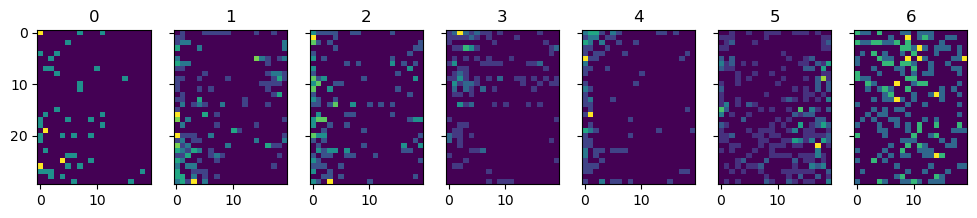

In [3]:
fig,ax = plt.subplots(1, 
                      spike_array.shape[1], 
                      figsize = (12,2), 
                      sharex=True, sharey=True
                     );
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(spike_array,0,1), ax.flatten())):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.set_title(ind)

# ============================

In [4]:
n_trials, nrn_num, time_bins = spike_array.shape
n_components = 2
n_states = 3


# Generate initvals for emission rates
# ======================================
# Average across sets of trials
mean_firing = np.stack(
    np.array_split(spike_array, n_components, axis=0)).mean(axis=1)
# Average across time
mean_firing = np.array_split(mean_firing, n_states, axis=2)
mean_firing = np.stack([x.mean(axis=-1) for x in mean_firing])


with pm.Model() as model:

    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    # trials x n_components
    w = pm.Dirichlet('w', a=alpha_w, shape = (n_trials,n_components))

    # Define Emissions

    # nrns
    nrn_lambda = pm.Exponential('nrn_lambda', 100, shape=(nrn_num))

    # nrns x switch_comps
    trial_lambda = pm.Exponential('comp_lambda',
                                  nrn_lambda.dimshuffle(0, 'x'),
                                  shape=(nrn_num, n_components))

    # nrns x n_components x n_states
    state_lambda = pm.Exponential('state_lambda',
                                  trial_lambda.dimshuffle(0, 1, 'x'),
                                  initval = mean_firing.T,
                                  shape=(nrn_num, n_components, n_states))

     # Define Changepoints
    # Assuming distribution of changepoints remains
    # the same across all trials

    a = pm.HalfCauchy('a_tau', 3., shape=n_states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape=n_states - 1)

    tau_latent = pm.Beta('tau_latent', a, b,
                         shape=(n_trials, n_states-1))

    # # Trials x Changepoints
    tau = pm.Deterministic('tau', time_bins * tau_latent)

    #################################################
    
    # Then, we can select state_emissions for every trial
    idx = np.arange(time_bins)

    # tau : Trials x Changepoints
    weight_stack = pm.math.sigmoid(
        idx[np.newaxis, :]-tau[:, :, np.newaxis])
    weight_stack = tt.concatenate(
        [np.ones((n_trials, 1, time_bins)), weight_stack], axis=1)
    inverse_stack = 1 - weight_stack[:, 1:]
    inverse_stack = tt.concatenate(
        [inverse_stack, np.ones((n_trials, 1, time_bins))], axis=1)

    # Trials x n_states x Time
    weight_stack = np.multiply(weight_stack, inverse_stack)

    #################################################
    # Trials x neurons x n_states
    selected_lambdas = pm.Deterministic(
        'selected_lambdas', 
        tt.math.tensordot(w,state_lambda, axes=(1,1)))

    # trials x neurons x time
    lambda_ = tt.sum(
        # trials x n_states x neurons x None        # trials n_states x None x time
        selected_lambdas.dimshuffle(0, 2, 1, 'x') * weight_stack.dimshuffle(0, 1, 'x', 2),
                     axis=1)

    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=spike_array)

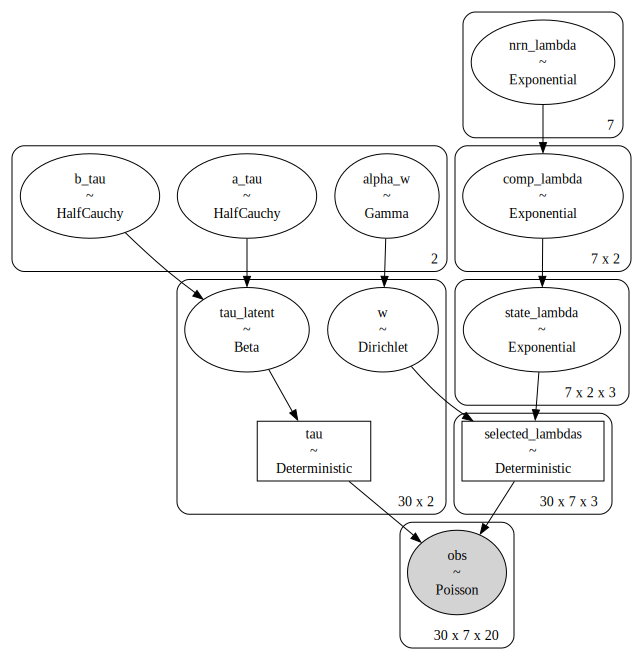

In [5]:
pm.model_to_graphviz(model)

In [6]:
with model:
    trace = pm.sample(nuts_sampler="numpyro", chains = 4, cores = 4)

/home/abuzarmahmood/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:04.864115
Sampling...


Compiling.. :   0%|                                                                                                                                        | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                                                                      | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                                                                        | 0/2000 [00:00<?, ?it/s]


  0%|                                                                                                                                                      | 0/2000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                                                                                                        | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                  

Sampling time =  0:00:30.011603
Transforming variables...
Transformation time =  0:00:00.557421


In [7]:
selected_lambdas_post = trace['posterior']['selected_lambdas'].values
w_post = trace['posterior']['w'].values

mean_selected_lambdas = selected_lambdas_post.mean(axis=(0,1))
mean_w = w_post.mean(axis=(1))

nrn_mean_lambdas = np.swapaxes(mean_selected_lambdas, 0,1)

In [8]:
mean_w.shape

(4, 30, 2)

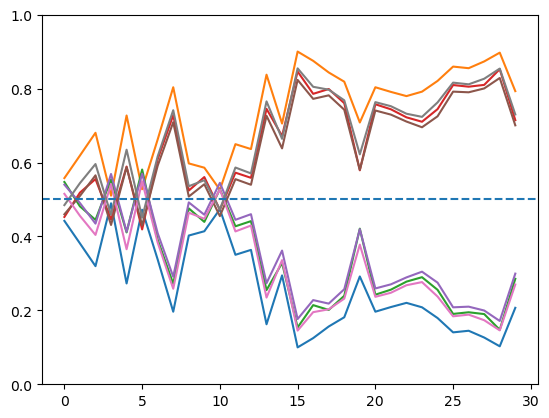

In [9]:
for chain in mean_w:
    plt.plot(chain)
plt.ylim(0,1)
plt.axhline(0.5, linestyle = '--')

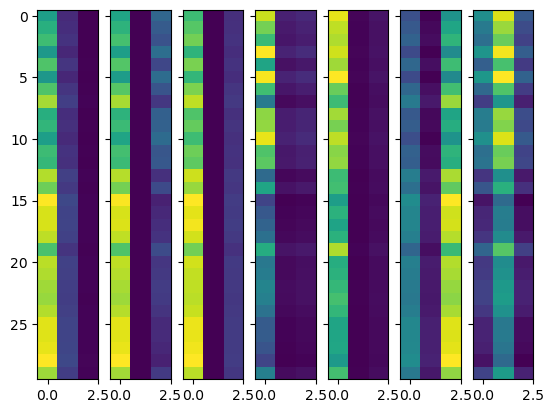

In [10]:
fig, ax = plt.subplots(1, len(nrn_mean_lambdas), sharex=True, sharey=True)
for this_ax, this_dat in zip(ax, nrn_mean_lambdas):
    this_ax.imshow(this_dat, aspect='auto')

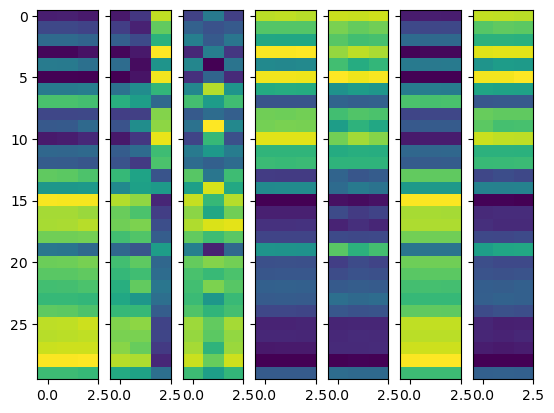

In [11]:
fig, ax = plt.subplots(1, len(nrn_mean_lambdas), sharex=True, sharey=True)
for this_ax, this_dat in zip(ax, nrn_mean_lambdas):
    this_ax.imshow(stats.zscore(this_dat,axis=0), aspect='auto')

In [12]:
tau_stack = trace['posterior']['tau'].values
int_tau = np.vectorize(int)(tau_stack)
mode_tau = np.squeeze(stats.mode(int_tau,axis=(0,1))[0])

Text(0, 0.5, 'Trial Number')

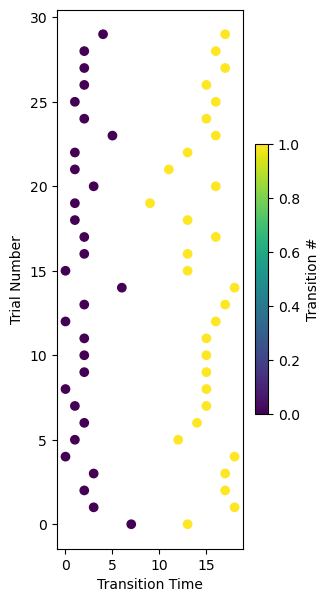

In [13]:
fig,ax = plt.subplots(figsize = (3,7))
for num, vals in enumerate(mode_tau):
    im = ax.scatter(vals,[num]*len(vals), c = range(len(vals)))
plt.colorbar(im, shrink = 0.5, label = 'Transition #')
plt.xlabel('Transition Time')
plt.ylabel('Trial Number')